# Import Libraries

In [2]:
import os
from google.colab import files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset

In [3]:
file_path = "loan_customer.csv"

if not os.path.exists(file_path):
    print("Please upload file.")
    uploaded = files.upload()

    # Verify if the correct file is uploaded
    if file_path not in uploaded.keys():
        raise FileNotFoundError("The file 'loan_customer.csv' was not uploaded.")

# Load the dataset
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe
df.head()

Please upload file.


Saving loan_customer.csv to loan_customer.csv


,loan_id,birth_date,phone_number,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_term_month,loan_term_year,credit_history,has_credit_card,property_type,loan_status
0,LP001002,1977-05-15,6.281142e+11,Male,No,0,Graduate,No,5849.0,0.0,100000,360,30,1.0,NaN,house,APPROVE
1,LP001003,1979-08-24,6.287764e+11,Male,Yes,1,Graduate,No,4583.0,1508.0,128000,360,30,1.0,NaN,studio,REJECT
2,LP001005,1991-03-28,6.281192e+11,Male,Yes,0,Graduate,Yes,3000.0,0.0,66000,360,30,1.0,NaN,house,APPROVE
3,LP001006,1980-06-02,6.285634e+10,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120000,360,30,1.0,NaN,house,APPROVE
4,LP001008,1989-05-19,6.281130e+11,Male,No,0,Graduate,No,6000.0,0.0,141000,360,30,1.0,NaN,house,APPROVE


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621 entries, 0 to 620
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   loan_id             621 non-null    object 
 1   birth_date          572 non-null    object 
 2   phone_number        569 non-null    float64
 3   gender              608 non-null    object 
 4   married             618 non-null    object 
 5   dependents          605 non-null    object 
 6   education           620 non-null    object 
 7   self_employed       588 non-null    object 
 8   applicant_income    612 non-null    float64
 9   coapplicant_income  621 non-null    float64
 10  loan_amount         621 non-null    int64  
 11  loan_term_month     621 non-null    int64  
 12  loan_term_year      621 non-null    int64  
 13  credit_history      570 non-null    float64
 14  has_credit_card     88 non-null     object 
 15  property_type       620 non-null    object 
 16  loan_sta

Result:
1. Dataset consist of 621 rows
2. There are some missing values in several columns
3. birth_date datatype must be addressed and normalized to integer

# Data Cleansing

## Handling missing values

In [5]:
df.isnull().sum()

loan_id                 0
birth_date             49
phone_number           52
gender                 13
married                 3
dependents             16
education               1
self_employed          33
applicant_income        9
coapplicant_income      0
loan_amount             0
loan_term_month         0
loan_term_year          0
credit_history         51
has_credit_card       533
property_type           1
loan_status             0
dtype: int64

In [6]:
#change birth_date datatype
df['birth_date']= pd.to_datetime(df['birth_date'])

In [7]:
# Drop the phone_number, has_credit_card column because there are so much missing values
df = df.drop(columns=['has_credit_card'])
df = df.drop(columns=['phone_number'])

In [8]:
# Impute missing values for categorical and numerical columns
categorical_cols = ['gender', 'married', 'dependents', 'education', 'self_employed', 'property_type']
numerical_cols = ['applicant_income', 'credit_history']

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

In [9]:
# Impute missing value for property_type
df['property_type'] = df['property_type'].fillna(df['property_type'].mode()[0])

df.dropna(inplace=True)

# Check if there are any missing values left
print(df.isnull().sum())

loan_id               0
birth_date            0
gender                0
married               0
dependents            0
education             0
self_employed         0
applicant_income      0
coapplicant_income    0
loan_amount           0
loan_term_month       0
loan_term_year        0
credit_history        0
property_type         0
loan_status           0
dtype: int64


## Handling duplicated data

In [10]:
# Check for duplicated rows
duplicate_rows = df[df.duplicated()]

# If duplicates are found, print them and decide how to handle
if not duplicate_rows.empty:
    print("Duplicate Rows:")
    print(duplicate_rows)

    # Remove duplicates, keeping only the first occurrence
    df.drop_duplicates(inplace=True)
    print("Duplicates removed.")
else:
    print("No duplicates found.")

Duplicate Rows:
      loan_id birth_date  gender married dependents     education  \
90   LP001310 1987-10-18    Male     Yes          0      Graduate   
279  LP001904 1986-01-30    Male     Yes          0      Graduate   
308  LP001990 1980-08-03    Male      No          0  Not Graduate   
363  LP002160 1990-11-27    Male     Yes         3+      Graduate   
401  LP002277 1972-06-12  Female      No          0      Graduate   

    self_employed  applicant_income  coapplicant_income  loan_amount  \
90             No            5695.0              4167.0       175000   
279            No            3103.0              1300.0        80000   
308            No            2000.0                 0.0       119000   
363            No            5167.0              3167.0       200000   
401            No            3180.0                 0.0        71000   

     loan_term_month  loan_term_year  credit_history property_type loan_status  
90               360              30             1.0   

In [11]:
df.duplicated().sum()

0

## Handling Outlier

In [12]:
# Function to remove outliers for a specific column using the IQR method
def remove_outliers_iqr_column(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Specify numerical columns where outliers need to be removed
numerical_cols = ['applicant_income', 'coapplicant_income', 'loan_amount']

# Copy of the original DataFrame before removing outliers
df_before = df.copy()

Distribution and outliers for column 'applicant_income':


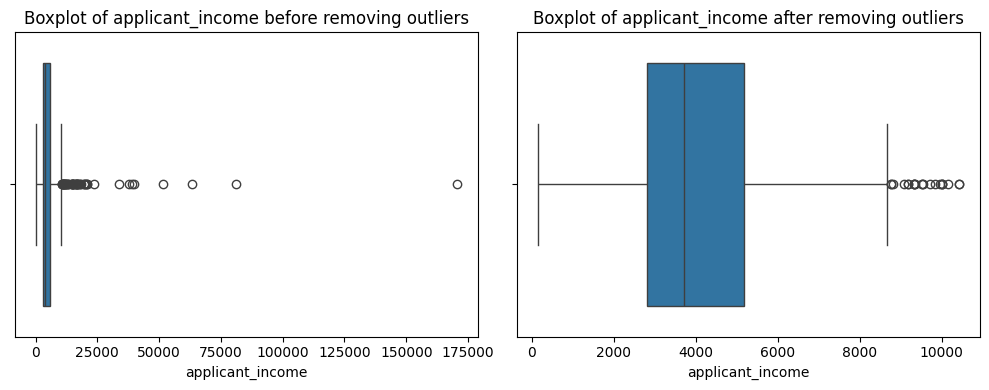

Distribution and outliers for column 'coapplicant_income':


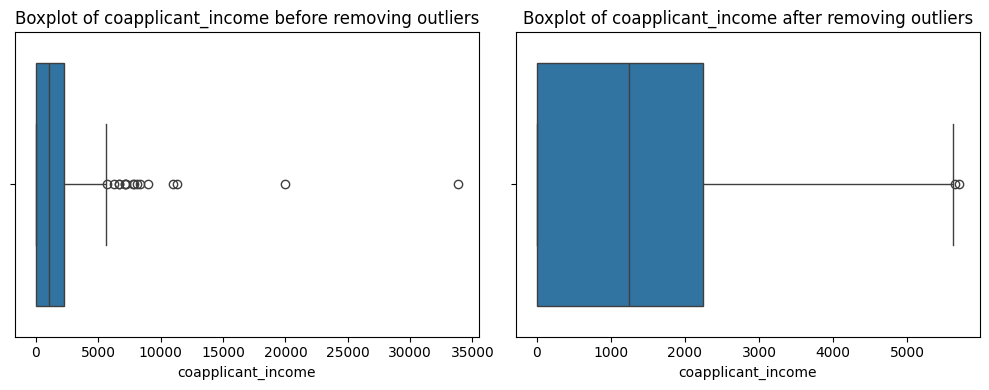

Distribution and outliers for column 'loan_amount':


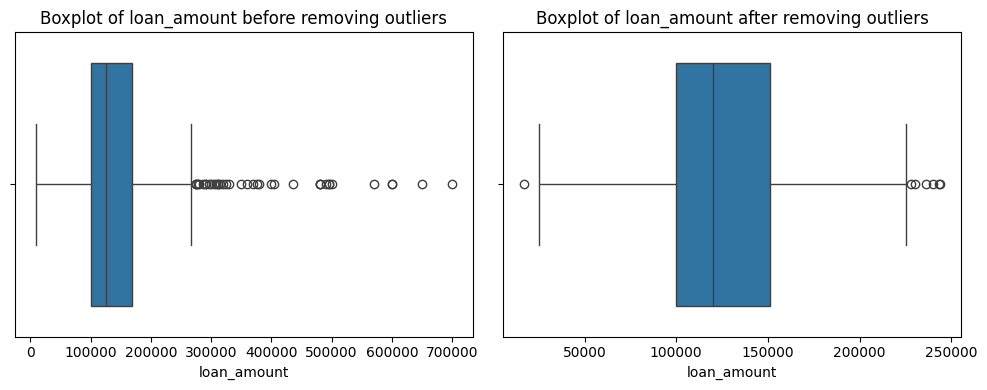

In [13]:
# Plot distribution and remove outliers for each numerical column
for col in numerical_cols:
    print(f"Distribution and outliers for column '{col}':")
    plt.figure(figsize=(10, 4))

    # Plot boxplot before removing outliers
    plt.subplot(1, 2, 1)
    sns.boxplot(x=col, data=df_before)
    plt.title(f'Boxplot of {col} before removing outliers')

    # Remove outliers for the current column
    df = remove_outliers_iqr_column(df, col)

    # Plot boxplot after removing outliers
    plt.subplot(1, 2, 2)
    sns.boxplot(x=col, data=df)
    plt.title(f'Boxplot of {col} after removing outliers')

    plt.tight_layout()
    plt.show()

In [14]:
# Print the number of rows before and after removing outliers
print('Number of rows before removing outliers:', len(df_before))
print('Number of rows after removing outliers:', len(df))

Number of rows before removing outliers: 567
Number of rows after removing outliers: 481


In [15]:
df.shape

(481, 15)

## Feature Encoding

In [16]:
# Perform one-hot encoding for categorical variables
df_encoded = pd.get_dummies(df, columns=['gender', 'married', 'dependents', 'education', 'self_employed', 'property_type', 'loan_status'])

# Display the encoded DataFrame
print("Encoded DataFrame:")
print(df_encoded.head())

Encoded DataFrame:
    loan_id birth_date  applicant_income  coapplicant_income  loan_amount  \
0  LP001002 1977-05-15            5849.0                 0.0       100000   
1  LP001003 1979-08-24            4583.0              1508.0       128000   
2  LP001005 1991-03-28            3000.0                 0.0        66000   
3  LP001006 1980-06-02            2583.0              2358.0       120000   
4  LP001008 1989-05-19            6000.0                 0.0       141000   

   loan_term_month  loan_term_year  credit_history  gender_Female  \
0              360              30             1.0          False   
1              360              30             1.0          False   
2              360              30             1.0          False   
3              360              30             1.0          False   
4              360              30             1.0          False   

   gender_Male  ...  dependents_3+  education_Graduate  \
0         True  ...          False           

In [17]:
df

,loan_id,birth_date,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_term_month,loan_term_year,credit_history,property_type,loan_status
0,LP001002,1977-05-15,Male,No,0,Graduate,No,5849.0,0.0,100000,360,30,1.0,house,APPROVE
1,LP001003,1979-08-24,Male,Yes,1,Graduate,No,4583.0,1508.0,128000,360,30,1.0,studio,REJECT
2,LP001005,1991-03-28,Male,Yes,0,Graduate,Yes,3000.0,0.0,66000,360,30,1.0,house,APPROVE
3,LP001006,1980-06-02,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120000,360,30,1.0,house,APPROVE
4,LP001008,1989-05-19,Male,No,0,Graduate,No,6000.0,0.0,141000,360,30,1.0,house,APPROVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,LP002964,1984-02-27,Male,Yes,2,Not Graduate,No,3987.0,1411.0,157000,360,30,1.0,studio,APPROVE
615,LP002974,1988-03-24,Male,Yes,0,Graduate,No,3232.0,1950.0,108000,360,30,1.0,studio,APPROVE
616,LP002978,1976-03-25,Female,No,0,Graduate,No,2900.0,0.0,71000,360,30,1.0,studio,APPROVE
617,LP002979,1987-01-26,Male,Yes,3+,Graduate,No,4106.0,0.0,40000,180,15,1.0,studio,APPROVE


# Business Insight

## Analysis of customer interest based on property type

---




In [18]:
df_prop = df.groupby(['gender', 'property_type']) ['loan_id'].count().reset_index()
df_prop.columns = ['gender', 'property_type', 'count']

df_prop

,gender,property_type,count
0,Female,apartment,45
1,Female,house,22
2,Female,studio,21
3,Male,apartment,141
4,Male,house,130
5,Male,studio,122


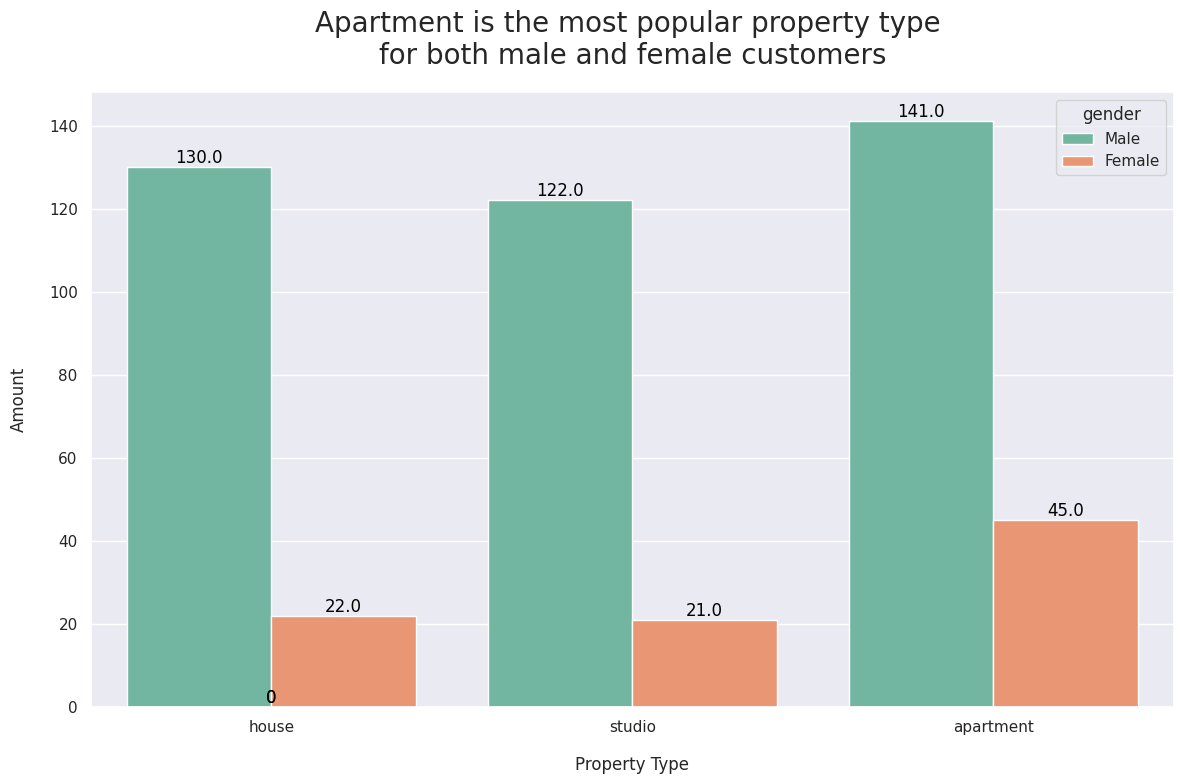

In [23]:
sns.set(style="darkgrid")
f, ax = plt.subplots(1,1,figsize=(12,8))
sns.countplot(x = 'property_type', data = df, hue = 'gender', palette = "Set2")

for bar in ax.patches:
    bar_value = bar.get_height()
    text = f'{bar_value:,}'
    text_x = bar.get_x() + bar.get_width() / 2
    text_y = bar.get_y() + bar_value
    bar_color = bar.get_facecolor()
    ax.text(text_x, text_y, text, ha='center', va='bottom', color='black', size=12)

ax.set_xlabel('Property Type', labelpad=15)
ax.set_ylabel('Amount', labelpad=15)
ax.set_title('Apartment is the most popular property type \nfor both male and female customers', pad=20, size=20)
plt.tight_layout()
plt.savefig('Analyze_the_behavior_of_loan_property_customers_01.png', dpi=200);

## Analysis of marital status on borrowing period

In [20]:
df_period = df.groupby(['married', 'loan_term_year'])['loan_id'].count().reset_index()
df_period.columns = ['married', 'loan_term_year', 'number_of_applicant']
df_period

,married,loan_term_year,number_of_applicant
0,No,3,2
1,No,5,1
2,No,10,1
3,No,15,6
4,No,20,1
5,No,25,3
6,No,30,151
7,No,40,7
8,Yes,1,1
9,Yes,5,1


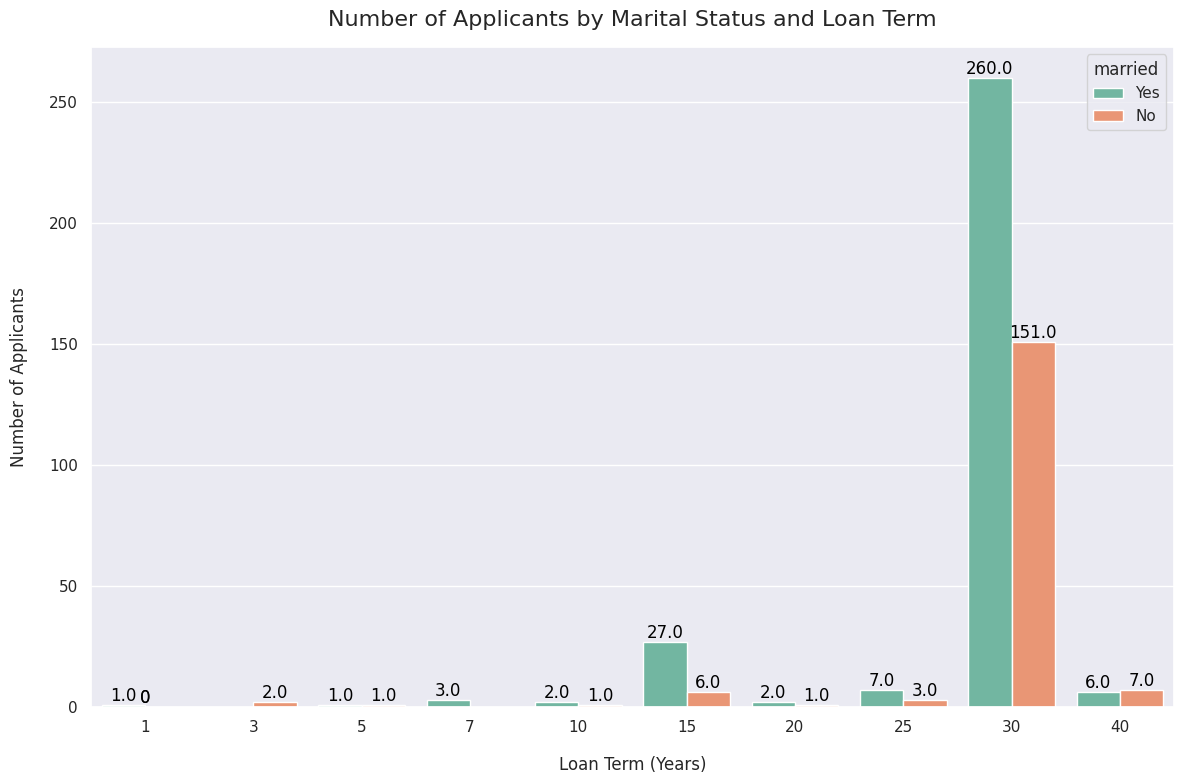

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='loan_term_year', y='number_of_applicant', hue='married', data=df_period, palette="Set2", ax=ax)
for bar in ax.patches:
    bar_value = bar.get_height()
    text = f'{bar_value:,}'
    text_x = bar.get_x() + bar.get_width() / 2
    text_y = bar.get_y() + bar_value
    bar_color = bar.get_facecolor()
    ax.text(text_x, text_y, text, ha='center', va='bottom', color='black', size=12)

# Set labels and title
ax.set_xlabel('Loan Term (Years)', labelpad=15)
ax.set_ylabel('Number of Applicants', labelpad=15)
ax.set_title('Number of Applicants by Marital Status and Loan Term', pad=15, size=16)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('Marital_Status_vs_Loan_Term.png', dpi=200)
plt.show()

##Summary

Based on the observations, we can draw the following conclusions regarding customer behavior:

As for the general customer profile, it can be stated that the majority of them, male and female, are interested in credit for purchasing apartments. This clearly points out that loan applicants greatly prefer the purchase of apartments.

From the preference analysis of the loan term based on the marital status of buyers, it becomes apparent that like any other customer, whether married or unmarried, the 30-year loan term term is optimal. This implies that 30 years’ term is the most preferred one by all customer types, inclusive of the married ones.

In addition there are a few more interesting trends observed for married customers. Marry applicants are equally considerate on loan tenure with 15 – 25 years loan tenor. It could be due to the fact that married souls may create double the income thus a duration of 15- 25 years of the loan seems right and reasonable.

Hence, from these observations, it can be inferred that strapped customers conventionally lean toward such a loan term length of 30 years irrespective of their status on marital context. Also, the probability of being a married customer increases the chances of choosing shorter loan periods and this may be credited to stability offered when two incomes are supplemented.

Created by Fajri Fathur Rahman

https://www.linkedin.com/in/fajrifathurrahman/